## LD and the relationship between marginal associations

We find that for logistic regression, across a range of allele frequencies and effect sizes that are reasonable in the GWAS context, that $z_2 \approx \rho z_1$.

In this notebook we first look at the asymptotic behavior of $z_2/z_1$ and show that it closely matches $\rho$. 
Then we use simulations to assess the normality of $z_2 - \rho z_1$.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
from correlated_bernoulli import coef2table, table2coef, px1x2, maximum_correlation
import jax.numpy as jnp

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def simulate_correlated_bernoulli(rho, p1, p2, n):
    rhomax = maximum_correlation(p1, p2)
    assert rho < rhomax
    x1 = np.random.binomial(1, p1, size=n)
    conditional_probabilities = px1x2(rho, p1, p2)[:, 1]
    x2 = np.random.binomial(1, conditional_probabilities[x1])
    return x1, x2
    
def simulate_logistic(b, b0, x):
    logit = (b0 + b * x).flatten()
    y = np.random.binomial(1, 1/(1 + np.exp(-logit)))
    return y

def compute_x2_asymptotic_mle(rho, p1, p2, b, b0):
    """
    compute limiting value of the MLE under logistic model to linked snp
    """
    A = px1x2(rho, p2, p1) # P(X_1 | X_2)
    B = coef2table(b0, b) # P(Y | X_1)
    C = A @ B # P (Y | X_2)
    coef_b2 = table2coef(C) # convert contingency table to (b0, b)
    return coef_b2
    
def row_normalize(A):
    return A/A.sum(1)[:, None]
    
def estimate_conditional_probabilities(x, y):
    # Sample estimate of P(Y | X)
    # Ensure inputs are numpy arrays
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Calculate the entries of the contingency table
    n00 = np.sum((x == 0) & (y == 0))
    n01 = np.sum((x == 0) & (y == 1))
    n10 = np.sum((x == 1) & (y == 0))
    n11 = np.sum((x == 1) & (y == 1))
    
    # Construct the 2x2 table
    table = np.array([[n00, n01],
                      [n10, n11]])
    return row_normalize(table)

def logistic_regression_mle(x, y):
    return np.array(table2coef(estimate_conditional_probabilities(x, y)))

def compute_asymptotic_wald_bernoulli(p, b, b0):
    """
    compute asymptotic Wald statistic, scale by sample size to predict W. 
    note that here we assume the intercept is estimated, and invert the information matrix
    """
    #return 0.5 * jnp.sum(
    #    jax.vmap(jax.grad(sigmoid))(np.array([b0, b0+b]).astype(float)) 
    #    * np.array([1-p, p]) 
    #    * jnp.array([0, b**2])
    #)
    h00 = sigmoid(b0) * sigmoid(-b0) * (1-p) + sigmoid(b0 + b) * sigmoid(-(b0 + b)) * p
    h01 = sigmoid(b0 + b) * sigmoid(-(b0 + b)) * p
    h11 = sigmoid(b0 + b) * sigmoid(-(b0 + b)) * p
    s2 = h00/(h00*h11 - h01**2)
    return b**2 / s2

def compute_wald(bhat, x):
    """
    compute the wald statistic
    only need x and bhat because second derivative does not depend on y
    """
    psi = bhat[0] + x * bhat[1]
    h = sigmoid(psi) * sigmoid(-psi)
    h00 = jnp.sum(sigmoid(psi) * sigmoid(-psi))
    h01 = jnp.sum(sigmoid(psi) * sigmoid(-psi) * x)
    h11 = jnp.sum(sigmoid(psi) * sigmoid(-psi) * x**2)
    s2 = h00 / (h00 * h11 - h01**2)
    #s2 = 1/h11
    return bhat[1]**2/s2

def relerr(a, b):
    """
    compute relative error
    """
    return np.abs(a-b)/np.abs(b)

In [2]:
#1. 
# simulate x
p1, p2, n = 0.1, 0.5, int(1e6)
rho = maximum_correlation(p1, p2)*0.9
x1, x2 = simulate_correlated_bernoulli(rho, p1, p2, n)

# simulate y
b, b0 = 1., -1.
y = simulate_logistic(b, b0, x1)

In [3]:
# check that we are simulating p(x1, x2) correctly
print(np.array([x1.mean()/p1, x2.mean()/p2, np.corrcoef(x1, x2)[1, 0]/rho]))

# compute MLE, see that the relative error for bhat1 to b and bhat2 to b2 are small
bhat1 = logistic_regression_mle(x1, y)
print(relerr(bhat1, np.array([b0, b])))

bhat2 = logistic_regression_mle(x2, y)
blim2 = compute_x2_asymptotic_mle(rho, p1, p2, b, b0)
print(relerr(bhat2, np.array(blim2)))

[0.99934    1.000796   0.99958754]
[1.38950348e-03 5.14984131e-05]
[0.00357273 0.0220901 ]


In [4]:
# compute Wald statistics
waldhat1 = compute_wald(bhat1, x1)/n
waldlim1 = compute_asymptotic_wald_bernoulli(p1, b, b0)
print(relerr(waldhat1, waldlim1))

0.0003870663669774888


In [5]:
# compute Wald statistics
waldhat2 = compute_wald(bhat2, x2)/n
waldlim2 = compute_asymptotic_wald_bernoulli(p2, blim2[1], blim2[0])
print(relerr(waldhat2, waldlim2))

0.04307856


### Main Result:

We consider when the causal variant is both commonm $p_1=0.5$ and rare $p_1=0.01$, as welle as when the allelic effect is small $b=0.2$ and large $b=2.0$. 
We see that when the effect size is small, $z_2/z_1 \approx \rho$, suggesting that summary statistic based fine-mapping could correctly control for the contribution of causal SNPs to association signal at linked sites.
When the effect size is larger, we see deviations of $z_2/z_1$ from $\rho$, abeit somewhat mild. 

In [6]:
def compute_asymptotic_z2_over_z1(rho, p1, p2, b, b0):
    waldlim1 = compute_asymptotic_wald_bernoulli(p1, b, b0)
    b2lim = compute_x2_asymptotic_mle(rho, p1, p2, b, b0)
    waldlim2 = compute_asymptotic_wald_bernoulli(p2, b2lim[1], b2lim[0])
    return np.sqrt(waldlim2/waldlim1)


def add_z2z1_plot(p1, p2, b, b0, **kwargs):
    rhomax = maximum_correlation(p1, p2)
    rhos = np.linspace(0, 1, 100) * rhomax
    z2z1 = np.array([compute_asymptotic_z2_over_z1(rho, p1, p2, b, b0) for rho in rhos])
    plt.plot(rhos, z2z1, **kwargs)

Text(0.5, 0.98, 'Small Effect')

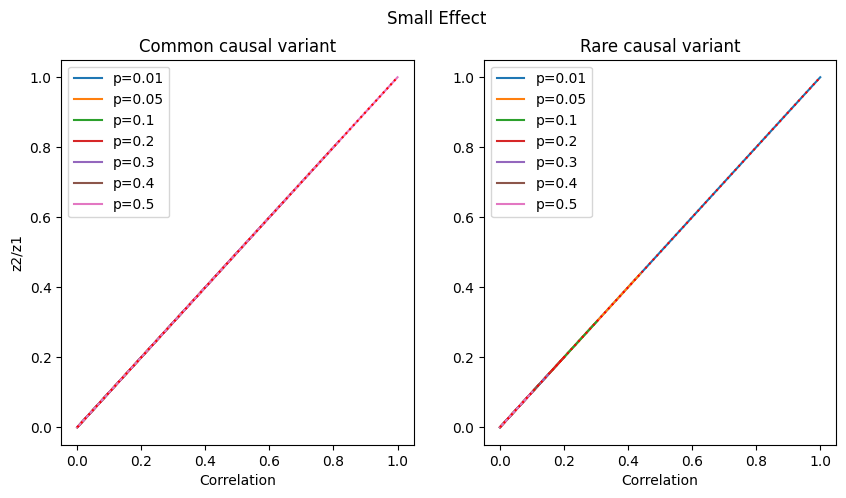

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
                       

ps = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
plt.sca(ax[0])
for p in ps:
    add_z2z1_plot(0.5, p, 0.1, -2., label=f'p={p}')
plt.plot([0, 1], [0, 1], c='r', linestyle='dotted')
plt.legend()
plt.ylabel('z2/z1')
plt.xlabel('Correlation')
plt.title('Common causal variant')

plt.sca(ax[1])
for p in ps:
    add_z2z1_plot(0.01, p, 0.1, -2., label=f'p={p}')
plt.plot([0, 1], [0, 1], c='r', linestyle='dotted')
plt.legend()
plt.xlabel('Correlation')
plt.title('Rare causal variant')

plt.suptitle('Small Effect')

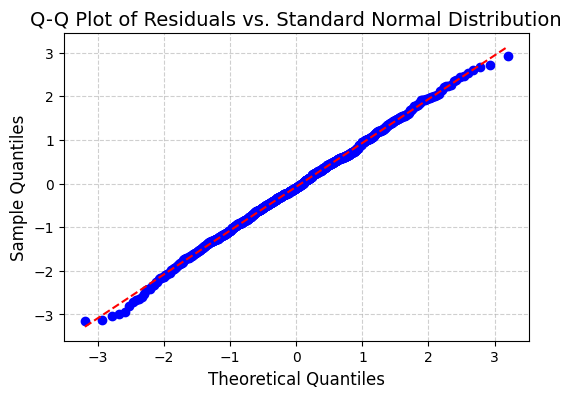

In [8]:
from scipy import stats

def simulate_residual_z(b, b0, p1, p2, n):
    rho = maximum_correlation(p1, p2)*0
    x1, x2 = simulate_correlated_bernoulli(rho, p1, p2, n)
    
    # simulate y
    y = simulate_logistic(b, b0, x1)
    
    # fit causal snp
    bhat1 = logistic_regression_mle(x1, y)
    waldhat1 = compute_wald(bhat1, x1)
    waldlim1 = compute_asymptotic_wald_bernoulli(p1, b, b0)
    z1 = np.sign(bhat1[1]) * np.sqrt(waldhat1)
    
    # fit linked snp
    bhat2 = logistic_regression_mle(x2, y)
    blim2 = compute_x2_asymptotic_mle(rho, p1, p2, b, b0)
    waldhat2 = compute_wald(bhat2, x2)
    z2 = np.sign(bhat2[1]) * np.sqrt(waldhat2)
    
    # get residua
    rhohat = np.corrcoef(x1, x2)[1, 0]
    z2_res = z2 - rhohat * z1
    
    return z2_res

z2_res = np.array([simulate_residual_z(0.1, -2., 0.1, 0.3, 10000) for _ in range(1000)])

# Plot 4: QQ plot residual z-scores for standard normal
fig, ax = plt.subplots(1, 1, figsize=(6,4))

stats.probplot(z2_res, dist="norm", plot=ax)
ax.get_lines()[1].set_linestyle('--')  # Make the reference line dashed
ax.set_title('Q-Q Plot of Residuals vs. Standard Normal Distribution', fontsize=14)
ax.set_xlabel('Theoretical Quantiles', fontsize=12)
ax.set_ylabel('Sample Quantiles', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)